In [1]:
# Importing all the necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

In [2]:
# Certain commands for using XGB on my pc
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


In [4]:
%matplotlib inline

In [8]:
# importing our dataset
dataset = pd.read_excel('C:/HTSCORETIMES2.xlsx' , 'Sheet1')

In [9]:
# Dropping duplicates
dataset = dataset.drop_duplicates()

In [10]:
dataset.head()

,HGTOTW,H_Tot_Gen_Draw,H_Tot_Gen_Lose,H_Tot_Spe_Win,H_Tot_Spe_Draw,H_Tot_Spe_Lose,H_Tot_Gen_GF,H_Tot_Gen_GA,H_Tot_Spe_GF,H_Tot_Spe_GA,...,"ov2,5gg","ov3,5gg",gen6hunders,gen6awunders,sph00p,spaw00p,gagnotta,assnogagnota,xnogagnota,diplonogagnota
0,8,2,2,5,0,1,20,10,10,5,...,0,0,3,3,0.0,0.2,1.080346,1.9,4.1,4.6
1,36,13,6,23,3,1,89,38,46,7,...,0,0,1,2,0.1,0.0,1.107143,1.6,4.7,7.8
3,34,13,6,22,3,1,85,36,44,6,...,1,0,3,3,0.1,0.1,NaN,NaN,NaN,NaN
5,33,4,2,18,2,0,101,30,48,10,...,0,0,4,2,0.1,0.1,NaN,NaN,NaN,NaN
6,33,12,6,21,3,1,82,34,42,5,...,1,0,4,2,0.1,0.1,NaN,NaN,NaN,NaN


In [ ]:
# A lot of info gathered, but in the course of this project i will explain
# what  I will be using

In [11]:
# I will only examine matches where the teams have played at least four games at home,
# and respectively the away teams have also played 4 away games, hoping that this 
# will demonstrate some sort of "behaviour". Column 298, has the info about the sum
# of home matches
dataset = dataset[dataset.iloc[:,298] >4]

In [13]:
# Taking a look at what we have left
dataset.shape

(68403, 354)

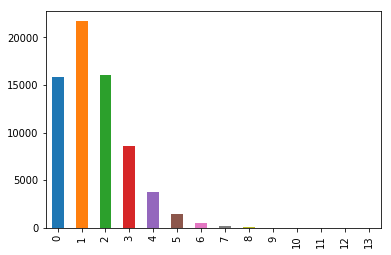

In [14]:
# My goal is to predict the possibility of a home team scoring or not. First I will 
# create the y variable. I have a column that states how many goals the home team has 
# scored('homegoals')
dataset['homegoals'].value_counts().sort_index().plot(kind = 'bar')

In [15]:
dataset['homegoals'].value_counts().sort_index()

0     15820
1     21733
2     16113
3      8634
4      3796
5      1431
6       549
7       202
8        70
9        29
10       12
11        7
12        4
13        3
Name: homegoals, dtype: int64

There are  15820 matches, in which the home team has not scored
Below i am creating the y variable using a simple lambda function

In [16]:
dataset['home_0'] = dataset['homegoals'].apply(lambda x: 1 if x == 0 else 0)

In [17]:
# Some descriptives about our y variable
dataset['home_0'].mean() # 23% of our matches ended with no goal scored for the home team.

0.23127640600558455

I will use all the info available from the oddsmakers, due to the fact that they
seem to be very accurate in the long term. What i mean is that ,if they say that a particular event
pays 3 X our money, then this number"hides" a probability of 1/3 on the event occcuring
( of course we should take into consideration the "gagnote","juice", the house fair profit, which slightly
changes this percentage). Anyway, I have gathered the odds from a very well known betting firm xxx365,
and I will use the odds for home win, draw , away win and also the odd for over2,5 goals, which also
gives us some info on whether it is likely that many goals will be scored. Apart from those, i also
choose to use something very "rational", the average home goals scored, when playing at home , 
and the average goals that the away team concedes, when playing away. My columns are 351,352,353,305,
316,319.


In [19]:
# I would like to check the target variable for missing values
dataset['home_0'].isnull().sum()


0

In [20]:
# Creation of a subset of my dataset
sub = dataset.iloc[:, [354,351,352,353,305,316,319]]

In [22]:
# Final column names
collist = sub.columns.tolist()

In [23]:
# Checking the features for missing values 
for col in collist:
    print(col,  sub[col].isnull().sum())

home_0 0
assnogagnota 2718
xnogagnota 2718
diplonogagnota 2718
oddov2,5arx 5150
hsptotgfavg 0
awsptotgagavg 561


In [24]:
# Taking a look at the results,i choose to drop all lines with missing values. 
sub = sub.dropna()

In [25]:
# Finally
y = sub.iloc[: , 0].values
X = sub.iloc[:, 1:].values

Next on I will follow some standard procedure steps, like imputing(while it is not necessary, I will
nevertheless apply it), splitting the dataset into training set  and test set, and i will also apply 
scaling, because I am thinking about using an ANN, so it is absolutely necessary.

In [26]:
#  TAKING CARE OF MISSING DATA
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis=0)
imputer = imputer.fit(X)
X = imputer.transform(X)

# splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X, y , test_size=0.2, stratify = y , random_state = 0)

# SCALING MY DATA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# I will compare two models, an XGB Regressor and a Keras ANN. I will use two ways of comparing them.
# The roc auc score  AND the error on their predictions on a completely new dataset. 

In [27]:
# Let us begin with the XGB
import xgboost as xgb
from xgboost import XGBRegressor
classifier = XGBRegressor(random_state = 42)

In [28]:
#Fitting the Model
classifier.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
# Predicting the result
y_pred = classifier.predict(X_test)

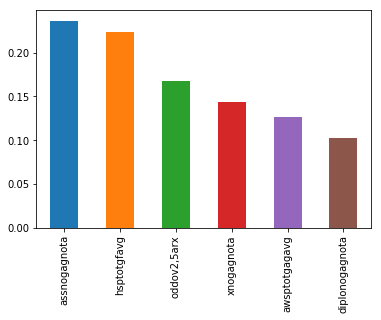

In [30]:
# I am curious about the feature importance of my variables. XGB has an attribute that will help us.
featuresdf = sub.iloc[: , 1:]
featimp = pd.Series(classifier.feature_importances_  ,index = featuresdf.columns )
featimp.sort_values(ascending = False).plot(kind = 'bar')

In [ ]:
# The top3 are odd of homewin, avg home goals, and odd of over2,5 goals.
# Or another way to interpret it would be that the first two outstand from 
# the others

# I will proceed to tuning of my regressor. Tune tree-specific parameters ( max_depth, min_child_weight) for default learning rate and number of trees. and through an iteration of possible values of our parameters, I will simultaneously perform k-foldvalidation, to investigate on bias and variance of my results

In [31]:
maxdepthlist = [2,3,4,5,6,7,8]
# the list that will contain the various average roc auc scores for each price of the max depth
scoreslist=[]
# list with the standard deviations of the above scores
scoresstdlist = []

In [32]:
for i in maxdepthlist:
        regressor = XGBRegressor(random_state = 42, max_depth = i)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        from sklearn.model_selection import cross_val_score
        from sklearn   import metrics
        scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, 
                                 scoring = 'roc_auc')
        print(scores.mean())
        print(scores.std())
        scoreslist.append(scores.mean())
        scoresstdlist.append(scores.std())

0.6482793710069383
0.007023386636800789
0.6482369727639414
0.007380314904116048
0.6468662128319671
0.007239263674892898
0.6450317353756811
0.006994539390862938
0.6416994327240853
0.006745967374586462
0.6372410418166444
0.006195670358821847
0.6294877865433005
0.0044706783988772425


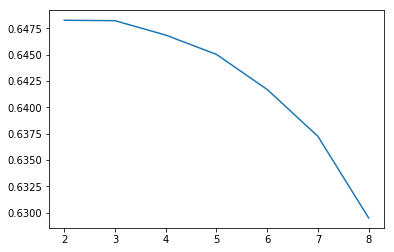

In [34]:
# I would like to take a look graphicly at the course of the auroc
pd.Series(scoreslist,maxdepthlist).plot()

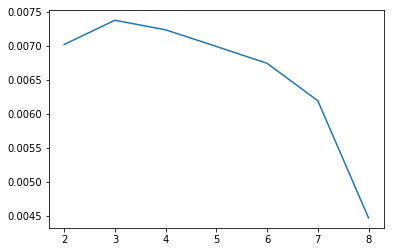

In [35]:
# And a look at the standard deviation respectively
pd.Series(scoresstdlist,maxdepthlist).plot()

# As we can see, the roc auc score , for values of max_depth =2 or 3, is quite good, because after that , it is declining. Regarding the std, it becomes smaller as max depth increases,after the value of 3, but simultaneously, the roc auc decreases, which is not good for our model. So we will keep the
# value of 2 and see how things develop

In [36]:
# Following the exact same way, we will tune the min child weight
scoreslist=[]
scoresstdlist = []
minchildlist = [2,3,4,5,6,7,8]       
for i in minchildlist:
        regressor = XGBRegressor(random_state = 42, max_depth = 2, min_child_weight = i)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        from sklearn.model_selection import cross_val_score
        from sklearn   import metrics
        scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, 
                                 scoring = 'roc_auc')
        print(scores.mean())
        print(scores.std())
        scoreslist.append(scores.mean())
        scoresstdlist.append(scores.std())

0.6482777125499961
0.007061315044723573
0.6482414804145197
0.006971564772327838
0.6483632858691732
0.007017132023574542
0.6484455213156782
0.007052131606611639
0.648386397830591
0.006995434464300557
0.648378454476907
0.006950075334057981
0.6484284741747912
0.007111802682763619


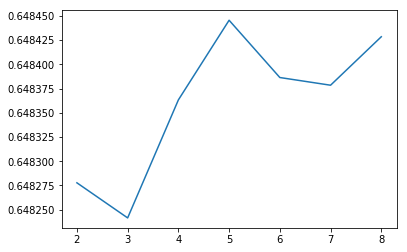

In [37]:
# Let us plot again        
pd.Series(scoreslist,minchildlist).plot()

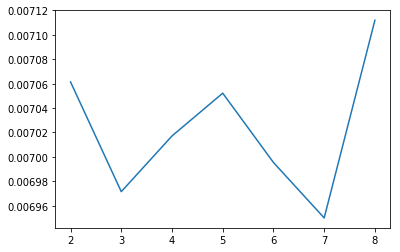

In [38]:
pd.Series(scoresstdlist,minchildlist).plot()

In [ ]:
# A comment. We can see that the improvements are very slight. The average roc auc score
# is between 0.64825 - 0.64845 and the std 0.00696 - 0.00712. So , I will just continue
# with a direction towards improving the roc score, meaning that I choose the min child
# value of 5

In [39]:
# Next, I will tune the "gamma" hyperparameter. I choose to use values, a little bit greater than its 
# defaultvalue of 0
scoreslist=[]
scoresstdlist = []
gammalist = [0.1,0.2,0.3,0.4,0.5]       
for i in gammalist:
        regressor = XGBRegressor(random_state = 42, max_depth = 2, min_child_weight = 5, gamma = i)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        from sklearn.model_selection import cross_val_score
        from sklearn   import metrics
        scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, 
                                 scoring = 'roc_auc')
        print(scores.mean())
        print(scores.std())
        scoreslist.append(scores.mean())
        scoresstdlist.append(scores.std())

0.6484455213156782
0.007052131606611639
0.6484039760118658
0.007068786214657578
0.6483098248437946
0.007042092685421956
0.6482445878341229
0.007046753723306891
0.648212083113502
0.007060741252048151


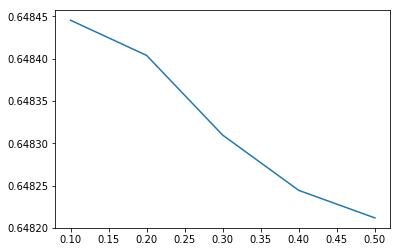

In [40]:
pd.Series(scoreslist,gammalist).plot()

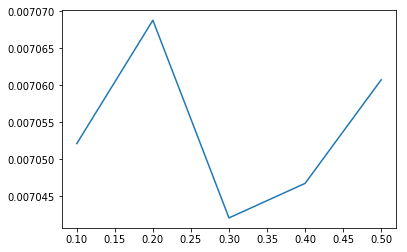

In [41]:
pd.Series(scoresstdlist,gammalist).plot()

In [ ]:
# Nothing changed towards improving the roc auc score.Lastly,two more things. We will reduce the 
# learning rate and increase the estimators. We will create the lrlist, which will contain various values
# for the learning_rate

In [42]:
scoreslist=[]
scoresstdlist = []
lrlist = [0.001,0.01,0.05,0.07,0.09,0.1]       
for i in lrlist:
        regressor = XGBRegressor(random_state = 42, max_depth = 2, min_child_weight = 5, 
                                 learning_rate = i)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        from sklearn.model_selection import cross_val_score
        from sklearn   import metrics
        scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, 
                                 scoring = 'roc_auc')
        print(scores.mean())
        print(scores.std())
        scoreslist.append(scores.mean())
        scoresstdlist.append(scores.std())

0.6385453834039061
0.006115526520933846
0.6445422820627469
0.006192086362142293
0.6480814224204585
0.007097215412414094
0.6484028095062635
0.007000708548776603
0.6485723871081215
0.006981901150914743
0.6484455213156782
0.007052131606611639


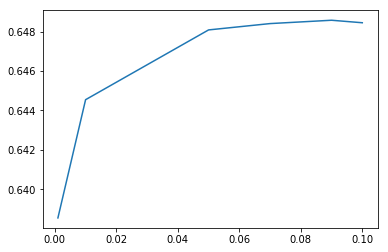

In [43]:
pd.Series(scoreslist,lrlist).plot()

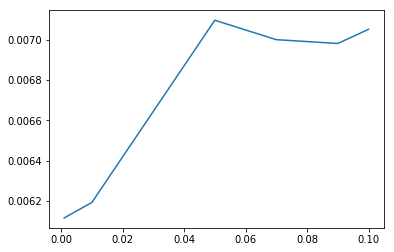

In [44]:
pd.Series(scoresstdlist,lrlist).plot()

In [45]:
# Judging by the graphs I will keep the 0.09 value
# Finally, let us see what happens regarding the estimators. 
scoreslist=[]
scoresstdlist = []
estimatorslist = [50,150,300,500,2000]       
for i in estimatorslist:
        regressor = XGBRegressor(random_state = 42, max_depth = 2, min_child_weight = 5, 
                                 learning_rate = 0.09, n_estimators = i)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        from sklearn.model_selection import cross_val_score
        from sklearn   import metrics
        scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, 
                                 scoring = 'roc_auc')
        print(scores.mean())
        print(scores.std())
        scoreslist.append(scores.mean())
        scoresstdlist.append(scores.std())

0.6480964070942694
0.006938428820770871
0.6486848782061293
0.0069549371059277445
0.647686981646164
0.006892099507219106
0.6464973466972476
0.006636143682267659
0.6412401909693928
0.007018457730646103


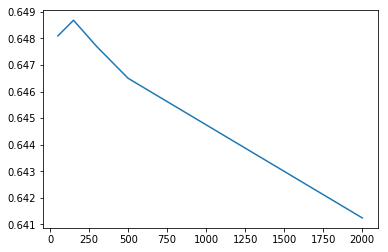

In [46]:
pd.Series(scoreslist,estimatorslist).plot()

In [ ]:
# It is straight forward that we keep 150 estimators

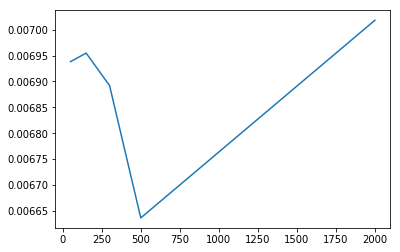

In [47]:
pd.Series(scoresstdlist,estimatorslist).plot()

In [ ]:
# Conclusion, for the XGB, I have reached a roc auc score of 0.6487 with a 0.007 std

In [48]:
# It is time now to train an ANN
# Importing KERAS
import keras
from keras.models import Sequential
from keras.layers import Dense

C:\Users\tolaros\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [49]:
# Initializing the ANN
neuron = Sequential() 

In [50]:
# I have come accross this implementation of incorporating roc auc score into a
# Keras model
import tensorflow as tf
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [51]:
# I will use just two hidden layers, the first will have 4 neurons and the second 3.
neuron.add(Dense(units = 4, activation = 'relu', kernel_initializer = 'glorot_uniform' ,input_dim = 6 ))
neuron.add(Dense(units = 3, activation = 'relu', kernel_initializer = 'glorot_uniform' ))
# Adding the output layer
neuron.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'glorot_uniform' ))
# Compiling the ANN. optimizer = function for the best weights, with stochastic gradient descent
# loss = loss function within stoch grad desc,using logarithmic loss 
# using binary_crossentropy for binary target variable
# metrics: apart form the default accuracy, i will also use the aurosc, that i have just above defined
neuron.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy', auroc])

In [52]:
#  FITTING THE ANN TO THE TRAINING SET
neuron.fit(X_train, y_train, batch_size = 50, epochs = 10)

Epoch 1/10
48895/48895 [==============================] - 7s 146us/step - loss: 0.5456 - acc: 0.7662 - auroc: 0.6207
Epoch 2/10
48895/48895 [==============================] - 4s 75us/step - loss: 0.5193 - acc: 0.7688 - auroc: 0.6383
Epoch 3/10
48895/48895 [==============================] - 4s 72us/step - loss: 0.5174 - acc: 0.7689 - auroc: 0.6444
Epoch 4/10
48895/48895 [==============================] - 4s 74us/step - loss: 0.5165 - acc: 0.7690 - auroc: 0.6473
Epoch 5/10
48895/48895 [==============================] - 4s 73us/step - loss: 0.5160 - acc: 0.7689 - auroc: 0.6480
Epoch 6/10
48895/48895 [==============================] - 4s 72us/step - loss: 0.5158 - acc: 0.7690 - auroc: 0.6505
Epoch 7/10
48895/48895 [==============================] - 4s 75us/step - loss: 0.5158 - acc: 0.7689 - auroc: 0.6477: 1s - loss: 
Epoch 8/10
48895/48895 [==============================] - 4s 73us/step - loss: 0.5157 - acc: 0.7690 - auroc: 0.6498
Epoch 9/10
48895/48895 [==============================] - 

In [ ]:
# The roc auc score is 0.651, almost identical to the 0.648 of the XGB. So what now remains, is to 
# make a comparison between the two graphs, that will demonstrate how close to reality are the 
# predictions of each model, when they are made on a "virgin" dataset. I have gathered matches
# from all the weekends betwween February to April 2018. The dataset has the same format with 
# our original dataset


In [53]:
# importing our 'virgin' dataset and preprocessing it
V = pd.read_excel('C:/PSKFEBEOSAPR18.xlsx')

In [54]:
V = V.drop_duplicates()

In [55]:
# creation of prediction column
V['home0'] = V['homegoals'].apply(lambda x:1 if x == 0 else 0)

In [56]:
# Creation of vector of prediction, like X
W = V.iloc[:, [407,408,409,305,315,318]].values

In [57]:
# scaling of our prediction vector
W2 = sc.transform(W)

In [58]:
# Retraining of our XGB
classifier= XGBRegressor(random_state = 42, max_depth = 2, min_child_weight = 5, 
                                 learning_rate = 0.09, n_estimators = 150)
classifier.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=2, min_child_weight=5, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [59]:
# predicting with our XGB
pred = classifier.predict(W2)

In [60]:
# creating a column with the predictions on V and rounding it on 2 decimals
V['predhomegoals_0'] = pred
V['predhomegoals_0'] = round(V['predhomegoals_0'],2)

In [61]:
# The goal now is to compare the XGB results to the "real" results of V
# For instance, if XGB predicted a 30% possibility on 100 games, we would
# expect that 30 out of those 100, will have the home team NOT TO HAVE SCORED.
# Is this true? We wil answer this by making a pivot table with the predictions 
# and the real percentage
xgbpiv = V.pivot_table(index = 'predhomegoals_0', values ='home0')

In [63]:
xgbpiv['predhomegoals_0'] = xgbpiv.index
# creating a count column
xgbpiv['count'] = V['predhomegoals_0'].value_counts().sort_index()
# making a 'deviation' column in the pivot table
xgbpiv['deviation'] = round((xgbpiv['home0'] - xgbpiv['predhomegoals_0']),2)
xgbpiv['absdeviation' ] = abs(xgbpiv['deviation'] )

In [64]:
xgbpiv

,home0,predhomegoals_0,count,deviation,absdeviation
predhomegoals_0,,,,,
0.02,0.000000,0.02,8,-0.02,0.02
0.03,0.125000,0.03,16,0.10,0.10
0.04,0.086957,0.04,23,0.05,0.05
0.05,0.083333,0.05,48,0.03,0.03
0.06,0.081633,0.06,49,0.02,0.02
0.07,0.064935,0.07,77,-0.01,0.01
0.08,0.053571,0.08,56,-0.03,0.03
0.09,0.060606,0.09,66,-0.03,0.03
0.10,0.120690,0.10,58,0.02,0.02


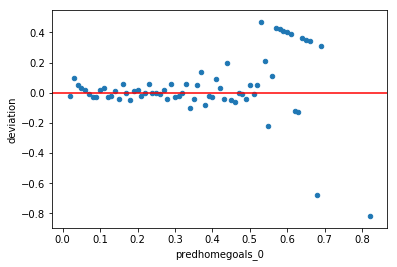

In [65]:
# Creating a plot with a red line, to depict the deviation from the "real" percentage
xgbpiv.plot.scatter('predhomegoals_0' , 'deviation')
plt.axhline(0, c = 'red')

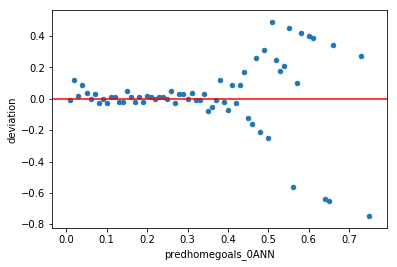

In [66]:
# acting the same way with the neuron
pred2 = neuron.predict(W2)
V['predhomegoals_0ANN'] = pred2
V['predhomegoals_0ANN'] = round(V['predhomegoals_0ANN'],2)

pinakasANN = V.pivot_table(index = 'predhomegoals_0ANN', values ='home0')
pinakasANN['predhomegoals_0ANN'] = pinakasANN.index

pinakasANN['count'] = V['predhomegoals_0ANN'].value_counts().sort_index()
pinakasANN['deviation'] = round((pinakasANN['home0'] - pinakasANN['predhomegoals_0ANN']),2)
pinakasANN['absdeviation' ] = abs(pinakasANN['deviation'] )

pinakasANN.plot.scatter('predhomegoals_0ANN' , 'deviation')
plt.axhline(0, c = 'red')

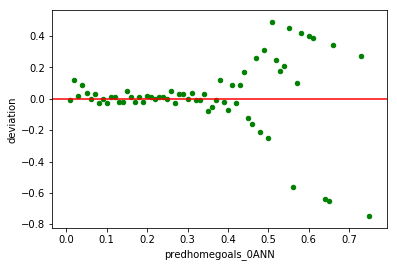

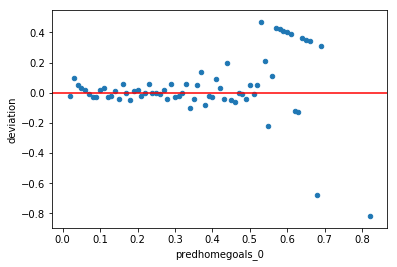

In [69]:
pinakasANN.plot.scatter('predhomegoals_0ANN' , 'deviation' , c = 'green')
plt.axhline(0, c = 'red')
xgbpiv.plot.scatter('predhomegoals_0' , 'deviation')
plt.axhline(0, c = 'red')

Some comments:
The ANN graph seems to  be a little bit closer to the red line, which is the ideal(deviation = 0)
We could also state that both models do not have such a good behaviour, when their predictions
start to exceed 40%. I would alike to check the mean absolute deviation for both models and their
std, by removing outliers, meaning that I will remove all instances from the pivot table, that occur
less than 30 times

In [70]:
xgbpiv2 = xgbpiv[xgbpiv['count'] >= 30]
print(xgbpiv2['absdeviation'].mean())
print(xgbpiv2['absdeviation'].std())




0.033157894736842115
0.028861764022233755


In [71]:
pinakasANN = pinakasANN[pinakasANN['count'] >= 30]
print(pinakasANN['absdeviation'].mean())
print(pinakasANN['absdeviation'].std())

0.02900000000000001
0.02771651363727278


Turns out that the ANN performs a little bit better. 